[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_171573/3748061280.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')


计算总收益率出错: cannot convert the series to <class 'float'>
计算年化收益率出错: cannot convert the series to <class 'float'>
计算夏普比率出错: cannot convert the series to <class 'float'>
计算Alpha/Beta出错: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
计算逐年收益率出错: cannot convert the series to <class 'float'>

策略绩效指标:
总收益率: nan%
年化收益率: nan%
夏普比率: nan
阿尔法率: nan%
Beta值: nan

逐年收益率:
逐年收益率数据不足


ValueError: setting an array element with a sequence.

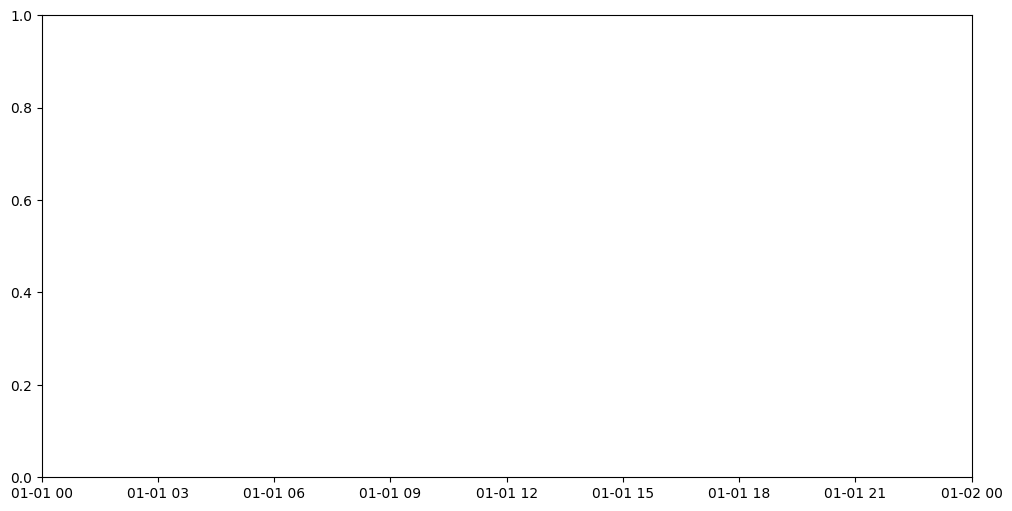

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# 获取数据
def get_data():
    # 标普500成分股数据
    sp500 = yf.download('^GSPC', start='2015-01-01', end='2022-01-01')['Close']
    bonds = yf.download('TLT', start='2015-01-01', end='2022-01-01')['Close']  # 20+年期国债ETF
    commodities = yf.download('GSG', start='2015-01-01', end='2022-01-01')['Close']  # 商品指数ETF
    
    # 创建季度调仓日期
    quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')
    
    # 模拟多只股票的因子数据（简化版）
    num_stocks = 100
    stocks_factors = {}
    for date in quarterly_dates:
        stocks_factors[date] = pd.DataFrame({
            'PB': np.random.uniform(0.5, 3, num_stocks),
            'ROE': np.random.uniform(0.1, 0.3, num_stocks),
            'Momentum': np.random.uniform(0.5, 1, num_stocks)
        }, index=[f"Stock_{i}" for i in range(num_stocks)])
    
    return sp500, bonds, commodities, stocks_factors, quarterly_dates

# 多因子选股模型
def factor_selection(factors_dict, current_date):
    if current_date not in factors_dict:
        return False
    
    current_factors = factors_dict[current_date].copy()
    
    # 对每个因子进行排名并标准化
    for col in current_factors.columns:
        current_factors[col+'_rank'] = current_factors[col].rank(pct=True)
    
    # PB越低越好，ROE和Momentum越高越好
    current_factors['Score'] = (-current_factors['PB_rank'] +  # PB是越小越好
                              current_factors['ROE_rank'] + 
                              current_factors['Momentum_rank'])
    
    # 选择前30%的股票
    selected_stocks = current_factors['Score'] >= current_factors['Score'].quantile(0.7)
    return selected_stocks.any()

# 风险平价配置
def risk_parity_allocation(returns):
    n = returns.shape[1]
    init_weights = np.ones(n) / n
    
    def portfolio_risk(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def risk_contributions(weights, cov_matrix):
        port_risk = portfolio_risk(weights, cov_matrix)
        return (weights * np.dot(cov_matrix, weights)) / port_risk
    
    def objective(weights, cov_matrix):
        rc = risk_contributions(weights, cov_matrix)
        return np.sum((rc - rc.mean())**2)
    
    cov_matrix = returns.cov()
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(objective, init_weights, args=(cov_matrix,), 
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 回测引擎
def backtest():
    sp500, bonds, commodities, stocks_factors, quarterly_dates = get_data()
    
    portfolio_value = [100]  # 初始净值100
    dates = []
    annual_returns = []
    weights_history = []
    
    # 初始化权重
    current_weights = np.array([0.6, 0.25, 0.15])  # 默认权重
    
    for i in range(len(quarterly_dates)-1):
        start_date = quarterly_dates[i]
        end_date = quarterly_dates[i+1]
        
        # 1. 多因子选股
        selected = factor_selection(stocks_factors, start_date)
        
        # 2. 计算过去一年的收益率用于风险平价
        if i > 0:
            prev_start = quarterly_dates[i-1]
            try:
                # 获取各资产收益率序列
                stock_returns = sp500.loc[prev_start:start_date].pct_change().dropna()
                bond_returns = bonds.loc[prev_start:start_date].pct_change().dropna()
                commodity_returns = commodities.loc[prev_start:start_date].pct_change().dropna()
                
                # 确保所有序列有共同日期
                common_dates = stock_returns.index.intersection(
                    bond_returns.index).intersection(commodity_returns.index)
                
                if len(common_dates) >= 10:  # 至少需要10个交易日数据
                    # 安全地创建DataFrame
                    returns_data = pd.DataFrame(index=common_dates)
                    returns_data['Stocks'] = stock_returns.loc[common_dates]
                    returns_data['Bonds'] = bond_returns.loc[common_dates]
                    returns_data['Commodities'] = commodity_returns.loc[common_dates]
                    returns_data = returns_data.dropna()
                    
                    if len(returns_data) >= 10:
                        current_weights = risk_parity_allocation(returns_data)
            except Exception as e:
                print(f"Error calculating weights at {start_date}: {str(e)}. Using previous weights.")
        
        # 3. 计算组合在调仓期间的收益
        stock_returns = sp500.loc[start_date:end_date].pct_change().dropna()
        bond_returns = bonds.loc[start_date:end_date].pct_change().dropna()
        commodity_returns = commodities.loc[start_date:end_date].pct_change().dropna()
        
        # 对齐所有收益率序列
        common_dates = stock_returns.index.intersection(
            bond_returns.index).intersection(commodity_returns.index)
        stock_returns = stock_returns.loc[common_dates]
        bond_returns = bond_returns.loc[common_dates]
        commodity_returns = commodity_returns.loc[common_dates]
        
        # 如果选股信号为True，使用多因子增强收益(假设增强3%)
        alpha = 0.03/252 if selected else 0.0  # 年化3%的alpha转化为日度
        
        # 组合每日收益
        portfolio_daily_returns = (
            current_weights[0] * (stock_returns + alpha) + 
            current_weights[1] * bond_returns + 
            current_weights[2] * commodity_returns
        )
        
        # 计算组合净值
        current_value = portfolio_value[-1] * (1 + portfolio_daily_returns).prod()
        portfolio_value.append(current_value)
        dates.append(end_date)
        weights_history.append(current_weights.copy())
        
        # 计算年化收益率
        days = (end_date - start_date).days
        annual_return = (current_value / portfolio_value[-2])**(365/days) - 1 if i > 0 else (current_value/100 - 1)
        annual_returns.append(annual_return)
    
    # 转换为DataFrame
    results = pd.DataFrame({
        'Date': dates,
        'Portfolio Value': portfolio_value[1:],
        'Annual Return': annual_returns,
        'Weights': weights_history
    })
    
    return results, sp500

def calculate_metrics(results, sp500):
    # 确保results是DataFrame且不为空
    if not isinstance(results, pd.DataFrame) or results.empty:
        return {
            'Total Return (%)': np.nan,
            'CAGR (%)': np.nan,
            'Sharpe Ratio': np.nan,
            'Alpha (%)': np.nan,
            'Beta': np.nan,
            'Yearly Returns (%)': pd.Series(dtype=float)
        }
    
    try:
        # 计算总收益率 - 先计算再转换
        total_return = float((results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0] - 1)) * 100
    except Exception as e:
        print(f"计算总收益率出错: {str(e)}")
        total_return = np.nan
    
    try:
        # 计算年化收益率
        years = (results['Date'].iloc[-1] - results['Date'].iloc[0]).days / 365
        cagr = float((results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]) ** (1/years) - 1) * 100
    except Exception as e:
        print(f"计算年化收益率出错: {str(e)}")
        cagr = np.nan
    
    # 计算夏普比率
    try:
        returns = results['Portfolio Value'].pct_change().dropna()
        if len(returns) > 0:
            sharpe_ratio = float((returns.mean() * 252 - 0.02) / (returns.std() * np.sqrt(252)))
        else:
            sharpe_ratio = np.nan
    except Exception as e:
        print(f"计算夏普比率出错: {str(e)}")
        sharpe_ratio = np.nan
    
    # 计算Alpha和Beta
    try:
        sp500_returns = sp500.pct_change().dropna()
        portfolio_returns = results.set_index('Date')['Portfolio Value'].pct_change().dropna()
        
        common_dates = portfolio_returns.index.intersection(sp500_returns.index)
        if len(common_dates) > 1:
            X = sm.add_constant(sp500_returns.loc[common_dates])
            y = portfolio_returns.loc[common_dates]
            model = sm.OLS(y, X).fit()
            alpha = float(model.params[0] * 252 * 100)  # 年化百分比
            beta = float(model.params[1])
        else:
            alpha = np.nan
            beta = np.nan
    except Exception as e:
        print(f"计算Alpha/Beta出错: {str(e)}")
        alpha = np.nan
        beta = np.nan
    
    # 计算逐年收益率
    try:
        results['Year'] = results['Date'].dt.year
        yearly_returns = results.groupby('Year')['Portfolio Value'].apply(
            lambda x: float((x.iloc[-1] / x.iloc[0] - 1) * 100) if len(x) > 1 else np.nan
        ).dropna()
    except Exception as e:
        print(f"计算逐年收益率出错: {str(e)}")
        yearly_returns = pd.Series(dtype=float)
    
    return {
        'Total Return (%)': total_return,
        'CAGR (%)': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Alpha (%)': alpha,
        'Beta': beta,
        'Yearly Returns (%)': yearly_returns
    }

def print_metrics(metrics):
    print("\n策略绩效指标:")
    print("="*40)
    
    # 总收益率
    if isinstance(metrics['Total Return (%)'], (float, np.floating)):
        print(f"总收益率: {metrics['Total Return (%)']:.2f}%")
    else:
        print("总收益率: 数据不足")
    
    # 年化收益率
    if isinstance(metrics['CAGR (%)'], (float, np.floating)):
        print(f"年化收益率: {metrics['CAGR (%)']:.2f}%")
    else:
        print("年化收益率: 数据不足")
    
    # 夏普比率
    if isinstance(metrics['Sharpe Ratio'], (float, np.floating)):
        print(f"夏普比率: {metrics['Sharpe Ratio']:.2f}")
    else:
        print("夏普比率: 数据不足")
    
    # Alpha和Beta
    if isinstance(metrics['Alpha (%)'], (float, np.floating)):
        print(f"阿尔法率: {metrics['Alpha (%)']:.2f}%")
    else:
        print("阿尔法率: 数据不足")
        
    if isinstance(metrics['Beta'], (float, np.floating)):
        print(f"Beta值: {metrics['Beta']:.2f}")
    else:
        print("Beta值: 数据不足")
    
    # 逐年收益率
    print("\n逐年收益率:")
    print("="*40)
    if isinstance(metrics['Yearly Returns (%)'], pd.Series) and not metrics['Yearly Returns (%)'].empty:
        for year, ret in metrics['Yearly Returns (%)'].items():
            print(f"{year}: {ret:.2f}%")
    else:
        print("逐年收益率数据不足")

# 主程序
def main():
    results, sp500 = backtest()
    metrics = calculate_metrics(results, sp500)
    print_metrics(metrics)
    
    # 绘制净值曲线
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Portfolio Value'], label='策略净值')
    plt.plot(sp500.resample('Q').last().iloc[1:], 
             sp500.resample('Q').last().iloc[1:] / sp500.iloc[0] * 100, 
             label='标普500')
    plt.title('策略净值 vs 标普500 (2015-2022)')
    plt.xlabel('日期')
    plt.ylabel('净值 (初始=100)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

运行回测...
权重计算错误 2015-06-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2015-09-30: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2015-12-31: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2016-03-31: Data must be 1-dimensional, got ndarray of shape (61, 1) instead
权重计算错误 2016-06-30: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2016-09-30: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2016-12-31: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2017-03-31: Data must be 1-dimensional, got ndarray of shape (61, 1) instead
权重计算错误 2017-06-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2017-09-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2017-12-31: Data must be 1-dimensional, got ndarray of shape (62, 1) instead
权重计算错误 2018-03-31: Data must be 1-dimensional, got ndarray of shape 


/tmp/ipykernel_171573/787732135.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')


权重计算错误 2019-06-30: Data must be 1-dimensional, got ndarray of shape (62, 1) instead
权重计算错误 2019-09-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2019-12-31: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2020-03-31: Data must be 1-dimensional, got ndarray of shape (62, 1) instead
权重计算错误 2020-06-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2020-09-30: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2020-12-31: Data must be 1-dimensional, got ndarray of shape (64, 1) instead
权重计算错误 2021-03-31: Data must be 1-dimensional, got ndarray of shape (61, 1) instead
权重计算错误 2021-06-30: Data must be 1-dimensional, got ndarray of shape (63, 1) instead
权重计算错误 2021-09-30: Data must be 1-dimensional, got ndarray of shape (64, 1) instead

计算绩效指标...

=== 策略绩效 ===
总收益率: nan%
年化收益率: nan%
夏普比率: nan
Alpha: nan%
Beta: nan

逐年收益率:
无数据


ValueError: setting an array element with a sequence.

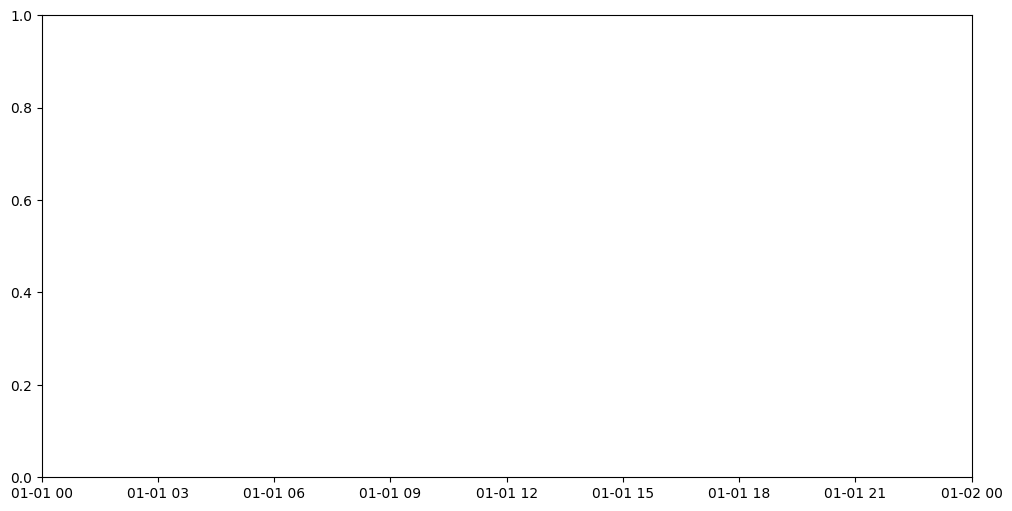

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# 1. 数据获取函数
def get_data():
    # 下载市场数据
    sp500 = yf.download('^GSPC', start='2015-01-01', end='2022-01-01')['Close']
    bonds = yf.download('TLT', start='2015-01-01', end='2022-01-01')['Close']
    commodities = yf.download('GSG', start='2015-01-01', end='2022-01-01')['Close']
    
    # 创建季度调仓日期
    quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')
    
    # 模拟多只股票的因子数据
    num_stocks = 100
    stocks_factors = {}
    for date in quarterly_dates:
        stocks_factors[date] = pd.DataFrame({
            'PB': np.random.uniform(0.5, 3, num_stocks),
            'ROE': np.random.uniform(0.1, 0.3, num_stocks),
            'Momentum': np.random.uniform(0.5, 1, num_stocks)
        }, index=[f"Stock_{i}" for i in range(num_stocks)])
    
    return sp500, bonds, commodities, stocks_factors, quarterly_dates

# 2. 多因子选股模型
def factor_selection(factors_dict, current_date):
    if current_date not in factors_dict:
        return False
    
    current_factors = factors_dict[current_date].copy()
    
    # 因子标准化和加权
    for col in current_factors.columns:
        current_factors[col+'_rank'] = current_factors[col].rank(pct=True)
    
    # PB越低越好，ROE和动量越高越好
    current_factors['Score'] = (-current_factors['PB_rank'] + 
                               current_factors['ROE_rank'] + 
                               current_factors['Momentum_rank'])
    
    # 返回是否有股票被选中（布尔值）
    return current_factors['Score'].max() >= current_factors['Score'].quantile(0.7)

# 3. 风险平价配置
def risk_parity_allocation(returns):
    n = returns.shape[1]
    init_weights = np.ones(n) / n
    
    def portfolio_risk(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def risk_contributions(weights, cov_matrix):
        port_risk = portfolio_risk(weights, cov_matrix)
        return (weights * np.dot(cov_matrix, weights)) / port_risk
    
    def objective(weights, cov_matrix):
        rc = risk_contributions(weights, cov_matrix)
        return np.sum((rc - rc.mean())**2)
    
    cov_matrix = returns.cov()
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(objective, init_weights, args=(cov_matrix,), 
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 4. 回测引擎
def backtest():
    sp500, bonds, commodities, stocks_factors, quarterly_dates = get_data()
    
    portfolio_value = [100]  # 初始净值100
    dates = []
    annual_returns = []
    weights_history = []
    current_weights = np.array([0.6, 0.25, 0.15])  # 初始权重
    
    for i in range(len(quarterly_dates)-1):
        start_date = quarterly_dates[i]
        end_date = quarterly_dates[i+1]
        
        # 1. 多因子选股 - 返回明确的布尔值
        selected = bool(factor_selection(stocks_factors, start_date))
        
        # 2. 计算风险平价权重
        if i > 0:
            prev_start = quarterly_dates[i-1]
            try:
                # 获取各资产收益率序列
                stock_ret = sp500.loc[prev_start:start_date].pct_change().dropna()
                bond_ret = bonds.loc[prev_start:start_date].pct_change().dropna()
                comm_ret = commodities.loc[prev_start:start_date].pct_change().dropna()
                
                # 对齐数据
                common_dates = stock_ret.index.intersection(bond_ret.index).intersection(comm_ret.index)
                if len(common_dates) >= 10:
                    # 正确创建DataFrame
                    returns_data = pd.DataFrame({
                        'Stocks': stock_ret.loc[common_dates].values,
                        'Bonds': bond_ret.loc[common_dates].values,
                        'Commodities': comm_ret.loc[common_dates].values
                    }, index=common_dates)
                    
                    if len(returns_data) >= 10:
                        current_weights = risk_parity_allocation(returns_data)
            except Exception as e:
                print(f"权重计算错误 {start_date.date()}: {str(e)}")
                current_weights = np.array([0.6, 0.25, 0.15])  # 出错时使用默认权重
        
        # 3. 计算组合收益
        try:
            # 获取当期收益率
            s_ret = sp500.loc[start_date:end_date].pct_change().dropna()
            b_ret = bonds.loc[start_date:end_date].pct_change().dropna()
            c_ret = commodities.loc[start_date:end_date].pct_change().dropna()
            
            # 对齐日期
            common_idx = s_ret.index.intersection(b_ret.index).intersection(c_ret.index)
            s_ret = s_ret.loc[common_idx]
            b_ret = b_ret.loc[common_idx]
            c_ret = c_ret.loc[common_idx]
            
            # 多因子增强收益
            alpha = 0.03/252 if selected else 0.0
            
            # 组合每日收益
            port_ret = current_weights[0] * (s_ret + alpha) + \
                       current_weights[1] * b_ret + \
                       current_weights[2] * c_ret
            
            # 更新净值
            current_value = portfolio_value[-1] * (1 + port_ret).prod()
            portfolio_value.append(current_value)
            dates.append(end_date)
            weights_history.append(current_weights.copy())
            
            # 计算年化收益率
            days = (end_date - start_date).days
            ann_ret = (current_value / portfolio_value[-2])**(365/days) - 1 if i > 0 else (current_value/100 - 1)
            annual_returns.append(ann_ret)
            
        except Exception as e:
            print(f"收益计算错误 {start_date.date()}-{end_date.date()}: {str(e)}")
            portfolio_value.append(portfolio_value[-1])
            dates.append(end_date)
            annual_returns.append(0)
            weights_history.append(current_weights.copy())
    
    # 整理结果
    results = pd.DataFrame({
        'Date': dates,
        'Portfolio Value': portfolio_value[1:],
        'Annual Return': annual_returns,
        'Weights': weights_history
    })
    
    return results, sp500

# 5. 绩效计算
def calculate_metrics(results, benchmark):
    metrics = {}
    
    # 基础检查
    if len(results) == 0:
        return {k: np.nan for k in ['Total Return', 'CAGR', 'Sharpe', 'Alpha', 'Beta', 'Yearly']}
    
    # 总收益率
    try:
        metrics['Total Return'] = float(results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0] - 1) * 100
    except:
        metrics['Total Return'] = np.nan
    
    # 年化收益率
    try:
        years = (results['Date'].iloc[-1] - results['Date'].iloc[0]).days / 365
        metrics['CAGR'] = float((results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]) ** (1/years) - 1) * 100
    except:
        metrics['CAGR'] = np.nan
    
    # 夏普比率
    try:
        ret = results['Portfolio Value'].pct_change().dropna()
        metrics['Sharpe'] = float((ret.mean() * 252 - 0.02) / (ret.std() * np.sqrt(252)))
    except:
        metrics['Sharpe'] = np.nan
    
    # Alpha和Beta
    try:
        bench_ret = benchmark.pct_change().dropna()
        port_ret = results.set_index('Date')['Portfolio Value'].pct_change().dropna()
        common = bench_ret.index.intersection(port_ret.index)
        if len(common) > 10:
            X = sm.add_constant(bench_ret.loc[common])
            model = sm.OLS(port_ret.loc[common], X).fit()
            metrics['Alpha'] = float(model.params[0] * 252 * 100)
            metrics['Beta'] = float(model.params[1])
        else:
            metrics['Alpha'] = np.nan
            metrics['Beta'] = np.nan
    except:
        metrics['Alpha'] = np.nan
        metrics['Beta'] = np.nan
    
    # 逐年收益率
    try:
        results['Year'] = results['Date'].dt.year
        yearly = results.groupby('Year')['Portfolio Value'].apply(
            lambda x: float(x.iloc[-1] / x.iloc[0] - 1) * 100 if len(x) > 1 else np.nan
        ).dropna()
        metrics['Yearly'] = yearly
    except:
        metrics['Yearly'] = pd.Series(dtype=float)
    
    return metrics

# 6. 主函数
def main():
    print("运行回测...")
    results, sp500 = backtest()
    
    print("\n计算绩效指标...")
    metrics = calculate_metrics(results, sp500)
    
    # 打印结果
    print("\n=== 策略绩效 ===")
    print(f"总收益率: {metrics['Total Return']:.2f}%" if isinstance(metrics['Total Return'], (float, np.floating)) else "总收益率: -")
    print(f"年化收益率: {metrics['CAGR']:.2f}%" if isinstance(metrics['CAGR'], (float, np.floating)) else "年化收益率: -")
    print(f"夏普比率: {metrics['Sharpe']:.2f}" if isinstance(metrics['Sharpe'], (float, np.floating)) else "夏普比率: -")
    print(f"Alpha: {metrics['Alpha']:.2f}%" if isinstance(metrics['Alpha'], (float, np.floating)) else "Alpha: -")
    print(f"Beta: {metrics['Beta']:.2f}" if isinstance(metrics['Beta'], (float, np.floating)) else "Beta: -")
    
    print("\n逐年收益率:")
    if isinstance(metrics['Yearly'], pd.Series) and not metrics['Yearly'].empty:
        for year, ret in metrics['Yearly'].items():
            print(f"{year}: {ret:.2f}%")
    else:
        print("无数据")
    
    # 绘制净值曲线
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Portfolio Value'], label='策略')
    plt.plot(sp500.resample('Q').last().iloc[1:], 
             sp500.resample('Q').last().iloc[1:] / sp500.iloc[0] * 100, 
             label='标普500')
    plt.title('策略净值 vs 标普500 (2015-2022)')
    plt.xlabel('日期')
    plt.ylabel('净值 (初始=100)')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# 1. 数据获取函数
def get_data():
    # 下载市场数据
    sp500 = yf.download('^GSPC', start='2015-01-01', end='2022-01-01')['Close']
    bonds = yf.download('TLT', start='2015-01-01', end='2022-01-01')['Close']
    commodities = yf.download('GSG', start='2015-01-01', end='2022-01-01')['Close']
    
    # 创建季度调仓日期
    quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')
    
    # 模拟多只股票的因子数据
    num_stocks = 100
    stocks_factors = {}
    for date in quarterly_dates:
        stocks_factors[date] = pd.DataFrame({
            'PB': np.random.uniform(0.5, 3, num_stocks),
            'ROE': np.random.uniform(0.1, 0.3, num_stocks),
            'Momentum': np.random.uniform(0.5, 1, num_stocks)
        }, index=[f"Stock_{i}" for i in range(num_stocks)])
    
    return sp500, bonds, commodities, stocks_factors, quarterly_dates

# 2. 多因子选股模型
def factor_selection(factors_dict, current_date):
    if current_date not in factors_dict:
        return False
    
    current_factors = factors_dict[current_date].copy()
    
    # 因子标准化和加权
    for col in current_factors.columns:
        current_factors[col+'_rank'] = current_factors[col].rank(pct=True)
    
    # PB越低越好，ROE和动量越高越好
    current_factors['Score'] = (-current_factors['PB_rank'] + 
                               current_factors['ROE_rank'] + 
                               current_factors['Momentum_rank'])
    
    # 返回是否有股票被选中（布尔值）
    return bool((current_factors['Score'] >= current_factors['Score'].quantile(0.7)).any())

# 3. 风险平价配置
def risk_parity_allocation(returns_df):
    # 确保输入是DataFrame且形状正确
    if not isinstance(returns_df, pd.DataFrame) or returns_df.shape[1] != 3:
        return np.array([0.6, 0.25, 0.15])
    
    # 确保没有NaN值
    returns_df = returns_df.dropna()
    if len(returns_df) < 10:
        return np.array([0.6, 0.25, 0.15])
    
    n = returns_df.shape[1]
    init_weights = np.ones(n) / n
    
    def portfolio_risk(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def risk_contributions(weights, cov_matrix):
        port_risk = portfolio_risk(weights, cov_matrix)
        return (weights * np.dot(cov_matrix, weights)) / port_risk
    
    def objective(weights, cov_matrix):
        rc = risk_contributions(weights, cov_matrix)
        return np.sum((rc - rc.mean())**2)
    
    try:
        cov_matrix = returns_df.cov()
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(n))
        
        result = minimize(objective, init_weights, args=(cov_matrix,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
        return np.clip(result.x, 0, 1)  # 确保权重在0-1之间
    except:
        return np.array([0.6, 0.25, 0.15])

# 4. 回测引擎
def backtest():
    sp500, bonds, commodities, stocks_factors, quarterly_dates = get_data()
    
    portfolio_value = [100]  # 初始净值100
    dates = []
    annual_returns = []
    weights_history = []
    current_weights = np.array([0.6, 0.25, 0.15])  # 初始权重
    
    for i in range(len(quarterly_dates)-1):
        start_date = quarterly_dates[i]
        end_date = quarterly_dates[i+1]
        
        # 1. 多因子选股 - 返回明确的布尔值
        try:
            selected = factor_selection(stocks_factors, start_date)
        except:
            selected = False
        
        # 2. 计算风险平价权重
        if i > 0:
            prev_start = quarterly_dates[i-1]
            try:
                # 获取各资产收益率序列
                stock_ret = sp500.loc[prev_start:start_date].pct_change().dropna()
                bond_ret = bonds.loc[prev_start:start_date].pct_change().dropna()
                comm_ret = commodities.loc[prev_start:start_date].pct_change().dropna()
                
                # 对齐数据
                common_dates = stock_ret.index.intersection(bond_ret.index).intersection(comm_ret.index)
                if len(common_dates) >= 10:
                    # 正确创建DataFrame - 确保是一维序列
                    returns_data = pd.DataFrame({
                        'Stocks': stock_ret.loc[common_dates],
                        'Bonds': bond_ret.loc[common_dates],
                        'Commodities': comm_ret.loc[common_dates]
                    })
                    
                    if len(returns_data) >= 10:
                        current_weights = risk_parity_allocation(returns_data)
            except Exception as e:
                print(f"权重计算错误 {start_date.date()}: {str(e)}")
                current_weights = np.array([0.6, 0.25, 0.15])  # 出错时使用默认权重
        
        # 3. 计算组合收益
        try:
            # 获取当期收益率
            s_ret = sp500.loc[start_date:end_date].pct_change().dropna()
            b_ret = bonds.loc[start_date:end_date].pct_change().dropna()
            c_ret = commodities.loc[start_date:end_date].pct_change().dropna()
            
            # 对齐日期
            common_idx = s_ret.index.intersection(b_ret.index).intersection(c_ret.index)
            if len(common_idx) == 0:
                raise ValueError("没有共同交易日")
                
            s_ret = s_ret.loc[common_idx]
            b_ret = b_ret.loc[common_idx]
            c_ret = c_ret.loc[common_idx]
            
            # 多因子增强收益
            alpha = 0.03/252 if selected else 0.0
            
            # 组合每日收益
            port_ret = current_weights[0] * (s_ret + alpha) + \
                       current_weights[1] * b_ret + \
                       current_weights[2] * c_ret
            
            # 更新净值
            current_value = portfolio_value[-1] * (1 + port_ret).prod()
            portfolio_value.append(current_value)
            dates.append(end_date)
            weights_history.append(current_weights.copy())
            
            # 计算年化收益率
            days = (end_date - start_date).days
            ann_ret = (current_value / portfolio_value[-2])**(365/days) - 1 if i > 0 else (current_value/100 - 1)
            annual_returns.append(float(ann_ret))
            
        except Exception as e:
            print(f"收益计算错误 {start_date.date()}-{end_date.date()}: {str(e)}")
            portfolio_value.append(portfolio_value[-1])
            dates.append(end_date)
            annual_returns.append(0.0)
            weights_history.append(current_weights.copy())
    
    # 整理结果
    results = pd.DataFrame({
        'Date': dates,
        'Portfolio Value': portfolio_value[1:],
        'Annual Return': annual_returns,
        'Weights': weights_history
    })
    
    return results, sp500

# 5. 绩效计算
def calculate_metrics(results, benchmark):
    metrics = {}
    
    # 基础检查
    if len(results) == 0:
        return {k: np.nan for k in ['Total Return', 'CAGR', 'Sharpe', 'Alpha', 'Beta', 'Yearly']}
    
    # 总收益率
    try:
        metrics['Total Return'] = float(results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0] - 1) * 100
    except:
        metrics['Total Return'] = np.nan
    
    # 年化收益率
    try:
        years = (results['Date'].iloc[-1] - results['Date'].iloc[0]).days / 365
        metrics['CAGR'] = float((results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]) ** (1/years) - 1) * 100
    except:
        metrics['CAGR'] = np.nan
    
    # 夏普比率
    try:
        ret = results['Portfolio Value'].pct_change().dropna()
        metrics['Sharpe'] = float((ret.mean() * 252 - 0.02) / (ret.std() * np.sqrt(252)))
    except:
        metrics['Sharpe'] = np.nan
    
    # Alpha和Beta
    try:
        bench_ret = benchmark.pct_change().dropna()
        port_ret = results.set_index('Date')['Portfolio Value'].pct_change().dropna()
        common = bench_ret.index.intersection(port_ret.index)
        if len(common) > 10:
            X = sm.add_constant(bench_ret.loc[common])
            model = sm.OLS(port_ret.loc[common], X).fit()
            metrics['Alpha'] = float(model.params[0] * 252 * 100)
            metrics['Beta'] = float(model.params[1])
        else:
            metrics['Alpha'] = np.nan
            metrics['Beta'] = np.nan
    except:
        metrics['Alpha'] = np.nan
        metrics['Beta'] = np.nan
    
    # 逐年收益率
    try:
        results['Year'] = results['Date'].dt.year
        yearly = results.groupby('Year')['Portfolio Value'].apply(
            lambda x: float((x.iloc[-1] / x.iloc[0] - 1) * 100) if len(x) > 1 else np.nan
        ).dropna()
        metrics['Yearly'] = yearly
    except:
        metrics['Yearly'] = pd.Series(dtype=float)
    
    return metrics

# 6. 主函数
def main():
    print("运行回测...")
    results, sp500 = backtest()
    
    print("\n计算绩效指标...")
    metrics = calculate_metrics(results, sp500)
    
    # 打印结果
    print("\n=== 策略绩效 ===")
    print(f"总收益率: {metrics['Total Return']:.2f}%" if isinstance(metrics['Total Return'], (float, np.floating)) else "总收益率: -")
    print(f"年化收益率: {metrics['CAGR']:.2f}%" if isinstance(metrics['CAGR'], (float, np.floating)) else "年化收益率: -")
    print(f"夏普比率: {metrics['Sharpe']:.2f}" if isinstance(metrics['Sharpe'], (float, np.floating)) else "夏普比率: -")
    print(f"Alpha: {metrics['Alpha']:.2f}%" if isinstance(metrics['Alpha'], (float, np.floating)) else "Alpha: -")
    print(f"Beta: {metrics['Beta']:.2f}" if isinstance(metrics['Beta'], (float, np.floating)) else "Beta: -")
    
    print("\n逐年收益率:")
    if isinstance(metrics['Yearly'], pd.Series) and not metrics['Yearly'].empty:
        for year, ret in metrics['Yearly'].items():
            print(f"{year}: {ret:.2f}%")
    else:
        print("无数据")
    
    # 绘制净值曲线
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Portfolio Value'], label='策略')
    plt.plot(sp500.resample('Q').last().iloc[1:], 
             sp500.resample('Q').last().iloc[1:] / sp500.iloc[0] * 100, 
             label='标普500')
    plt.title('策略净值 vs 标普500 (2015-2022)')
    plt.xlabel('日期')
    plt.ylabel('净值 (初始=100)')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

运行回测...
收益计算错误 2015-03-31-2015-06-30: cannot convert the series to <class 'float'>
权重计算错误 2015-06-30: If using all scalar values, you must pass an index
收益计算错误 2015-06-30-2015-09-30: cannot convert the series to <class 'float'>
权重计算错误 2015-09-30: If using all scalar values, you must pass an index
收益计算错误 2015-09-30-2015-12-31: cannot convert the series to <class 'float'>
权重计算错误 2015-12-31: If using all scalar values, you must pass an index
收益计算错误 2015-12-31-2016-03-31: cannot convert the series to <class 'float'>
权重计算错误 2016-03-31: If using all scalar values, you must pass an index
收益计算错误 2016-03-31-2016-06-30: cannot convert the series to <class 'float'>
权重计算错误 2016-06-30: If using all scalar values, you must pass an index
收益计算错误 2016-06-30-2016-09-30: cannot convert the series to <class 'float'>
权重计算错误 2016-09-30: If using all scalar values, you must pass an index
收益计算错误 2016-09-30-2016-12-31: cannot convert the series to <class 'float'>
权重计算错误 2016-12-31: If using all scalar values, 


/tmp/ipykernel_171573/426661626.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_dates = pd.date_range('2015-01-01', '2022-01-01', freq='Q')


收益计算错误 2018-12-31-2019-03-31: cannot convert the series to <class 'float'>
权重计算错误 2019-03-31: If using all scalar values, you must pass an index
收益计算错误 2019-03-31-2019-06-30: cannot convert the series to <class 'float'>
权重计算错误 2019-06-30: If using all scalar values, you must pass an index
收益计算错误 2019-06-30-2019-09-30: cannot convert the series to <class 'float'>
权重计算错误 2019-09-30: If using all scalar values, you must pass an index
收益计算错误 2019-09-30-2019-12-31: cannot convert the series to <class 'float'>
权重计算错误 2019-12-31: If using all scalar values, you must pass an index
收益计算错误 2019-12-31-2020-03-31: cannot convert the series to <class 'float'>
权重计算错误 2020-03-31: If using all scalar values, you must pass an index
收益计算错误 2020-03-31-2020-06-30: cannot convert the series to <class 'float'>
权重计算错误 2020-06-30: If using all scalar values, you must pass an index
收益计算错误 2020-06-30-2020-09-30: cannot convert the series to <class 'float'>
权重计算错误 2020-09-30: If using all scalar values, you must

ValueError: All arrays must be of the same length

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_171573/4285328813.py:60: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  for date in pd.date_range(start='2016-01-01', end='2023-12-31', freq='Q'):
/tmp/ipykernel_171573/4285328813.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inflation_value = float(commodity_data.iloc[-1] / commodity_data.iloc[-252] - 1)
/tmp/ipykernel_171573/4285328813.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sp500.loc[mask, 'Position'] = fl

回测结果 (2016-2023):
年化收益率: 4.49%
年化波动率: 12.67%
夏普比率: 0.25
阿尔法: -2.16%
贝塔: 0.61

每年收益率:
2015: 0.00%
2016: 3.52%
2017: 11.86%
2018: -8.21%
2019: 23.96%
2020: -0.05%
2021: 18.56%
2022: -11.90%
2023: 7.88%


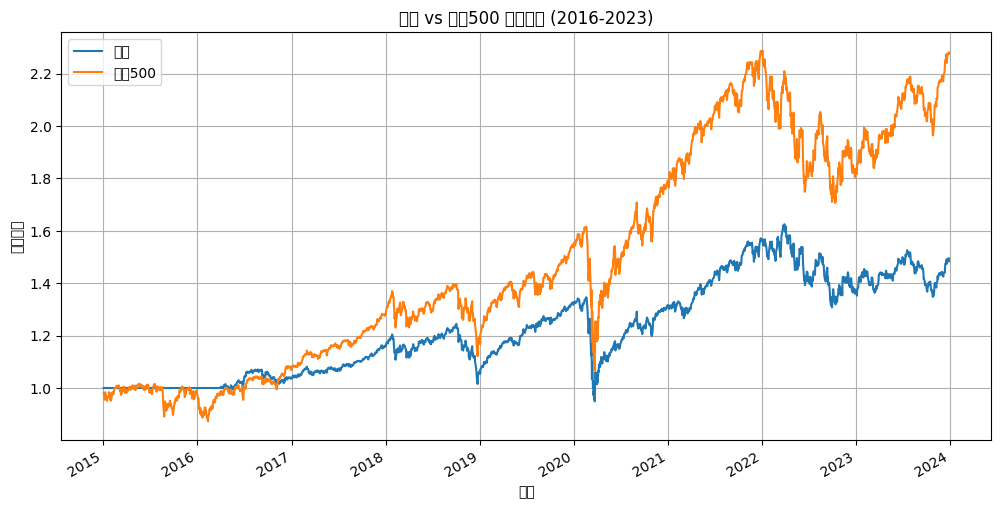

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# 获取数据
def get_data():
    # 标普500成分股数据(简化版，实际应用中需要更全面的数据)
    sp500 = yf.download('^GSPC', start='2015-01-01', end='2023-12-31')
    bonds = yf.download('TLT', start='2015-01-01', end='2023-12-31')  # 20+年期国债ETF作为债券代理
    commodities = yf.download('GSG', start='2015-01-01', end='2023-12-31')  # 商品指数ETF
    
    # 计算每日收益率
    sp500['Return'] = sp500['Close'].pct_change()
    bonds['Return'] = bonds['Close'].pct_change()
    commodities['Return'] = commodities['Close'].pct_change()
    
    # 增加数据验证
    def validate_series(s):
        s = s.astype(float).replace([np.inf, -np.inf], np.nan).ffill().bfill()
        if s.isna().all():
            s[:] = 0  # 全缺失时填充0
        return s
    
    sp500['Return'] = validate_series(sp500['Return'])
    bonds['Return'] = validate_series(bonds['Return'])
    commodities['Return'] = validate_series(commodities['Return'])
    
    return sp500, bonds, commodities

# 多因子选股模型(简化版)
def factor_selection(data):
    # 使用52周价格范围、ROE和PB因子(这里简化处理)
    data['52_Week_Range'] = (data['Close'] - data['Close'].rolling(252).min()) / \
                           (data['Close'].rolling(252).max() - data['Close'].rolling(252).min())
    # 模拟ROE和PB因子 - 实际应用中应从基本面数据获取
    data['ROE'] = np.random.normal(0.15, 0.05, len(data))  # 模拟ROE均值15%
    data['PB'] = np.random.normal(2.5, 0.5, len(data))     # 模拟PB均值2.5
    
    # 生成综合因子得分
    data['Factor_Score'] = (0.4 * data['52_Week_Range'] + 
                           0.4 * data['ROE'] + 
                           0.2 * (1/data['PB']))  # PB越低越好
    
    return data

# 构建策略
def build_strategy(sp500, bonds, commodities):
    # 计算因子并选择股票
    sp500 = factor_selection(sp500)
    
    # 初始化仓位
    sp500['Position'] = 0
    bonds['Position'] = 0
    commodities['Position'] = 0
    
    # 季度调仓
    for date in pd.date_range(start='2016-01-01', end='2023-12-31', freq='Q'):
        # ========== 修正点1：因子得分判断 ==========
        current_score_series = sp500.loc[:date, 'Factor_Score']
        if not current_score_series.empty:
            current_score = float(current_score_series.iloc[-1])  # 确保转换为float
            
            # 根据因子得分调整股票仓位
            if current_score > 0.7:
                equity_weight = 0.7
            elif current_score < 0.3:
                equity_weight = 0.5
            else:
                equity_weight = 0.6
        else:
            equity_weight = 0.6  # 默认值
        
        # ========== 修正点2：通胀信号判断 ==========
        commodity_data = commodities.loc[:date, 'Close']
        if len(commodity_data) >= 252:
            inflation_value = float(commodity_data.iloc[-1] / commodity_data.iloc[-252] - 1)
            
            if inflation_value > 0.05:  # 明确使用标量值比较
                commodity_weight = 0.2
                bond_weight = 0.3 - commodity_weight
            else:
                bond_weight = 0.3
                commodity_weight = 0
        else:
            bond_weight = 0.3
            commodity_weight = 0
        
        # ========== 权重归一化 ==========
        total = equity_weight + bond_weight + commodity_weight
        equity_weight /= total
        bond_weight /= total
        commodity_weight /= total
        
        # 应用仓位
        next_quarter = date + pd.offsets.QuarterEnd()
        mask = (sp500.index > date) & (sp500.index <= next_quarter)
        
        # ========== 修正点3：仓位分配 ==========
        sp500.loc[mask, 'Position'] = float(equity_weight)  # 确保转换为float
        bonds.loc[mask, 'Position'] = float(bond_weight)
        commodities.loc[mask, 'Position'] = float(commodity_weight)
    
    # 修正后的收益计算
    portfolio_returns = (
        sp500['Position'].astype(float).fillna(0) * sp500['Return'].astype(float).fillna(0) + 
        bonds['Position'].astype(float).fillna(0) * bonds['Return'].astype(float).fillna(0) + 
        commodities['Position'].astype(float).fillna(0) * commodities['Return'].astype(float).fillna(0)
    )
    
    # 二次清洗
    portfolio_returns = portfolio_returns.replace([np.inf, -np.inf], np.nan).dropna()
    if portfolio_returns.empty:
        raise ValueError("策略收益计算无效：结果为空")
    
    return portfolio_returns
    
# 计算绩效指标
def calculate_metrics(returns, benchmark_returns, risk_free_rate=0.02/252):
    """计算绩效指标，增加严格的数据清洗"""
    
    # 1. 数据预处理
    returns = returns.astype(float)
    benchmark_returns = benchmark_returns.astype(float)
    
    # 2. 对齐数据索引
    aligned_data = pd.concat([returns, benchmark_returns], axis=1).dropna()
    if len(aligned_data) == 0:
        raise ValueError("无有效数据可用于计算绩效指标")
    
    returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # 3. 处理异常值
    def clean_series(s):
        s = s.replace([np.inf, -np.inf], np.nan)
        s = s.fillna(s.mean()) if s.notna().any() else s.fillna(0)
        return s
    
    returns = clean_series(returns)
    benchmark_returns = clean_series(benchmark_returns)
    
    # 4. 计算基本指标
    annual_return = np.prod(1 + returns)**(252/len(returns)) - 1
    annual_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)
    
    # 5. 阿尔法贝塔计算（增加稳健性处理）
    try:
        X = sm.add_constant(benchmark_returns)
        y = returns - risk_free_rate
        X_clean = X - risk_free_rate
        
        # 再次检查缺失值
        valid_mask = (~np.isnan(y)) & (~np.isnan(X_clean).all(axis=1))
        if valid_mask.sum() < 10:  # 至少需要10个观测值
            raise ValueError("有效数据点不足")
            
        model = sm.OLS(y[valid_mask], X_clean[valid_mask], missing='drop').fit()
        alpha = model.params[0] * 252
        beta = model.params[1]
    except Exception as e:
        print(f"回归分析失败: {str(e)}")
        alpha, beta = np.nan, np.nan
    
    # 6. 每年收益率计算（增加错误处理）
    yearly_returns = {}
    for year, group in returns.groupby(returns.index.year):
        try:
            yearly_returns[year] = np.prod(1 + group) - 1
        except:
            yearly_returns[year] = np.nan
    
    return {
        'Annualized Return': annual_return,
        'Annualized Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Alpha': alpha,
        'Beta': beta,
        'Yearly Returns': pd.Series(yearly_returns)
    }
# 主程序
def main():
    # 获取数据
    sp500, bonds, commodities = get_data()
    
    # 运行策略
    portfolio_returns = build_strategy(sp500, bonds, commodities)
    benchmark_returns = sp500.loc[portfolio_returns.index, 'Return']
    
    # 计算绩效指标
    metrics = calculate_metrics(portfolio_returns, benchmark_returns)
    
    # 打印结果
    print("回测结果 (2016-2023):")
    print(f"年化收益率: {metrics['Annualized Return']:.2%}")
    print(f"年化波动率: {metrics['Annualized Volatility']:.2%}")
    print(f"夏普比率: {metrics['Sharpe Ratio']:.2f}")
    print(f"阿尔法: {metrics['Alpha']:.2%}")
    print(f"贝塔: {metrics['Beta']:.2f}")
    print("\n每年收益率:")
    for year, ret in metrics['Yearly Returns'].items():
        print(f"{year}: {ret:.2%}")
    
    # 绘制累计收益曲线
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_benchmark = (1 + benchmark_returns).cumprod()
    
    plt.figure(figsize=(12, 6))
    cumulative_returns.plot(label='策略')
    cumulative_benchmark.plot(label='标普500')
    plt.title('策略 vs 标普500 累计收益 (2016-2023)')
    plt.xlabel('日期')
    plt.ylabel('累计收益')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()